In [25]:
import pandas as pd
import numpy as np

In [26]:
tf_df = pd.read_csv("/home/akshai/Desktop/other_projects/Henrik_environmental_project/analysis_for_henrik/data_to_plot/concentration.csv") # Results from tracefinder where compounds and their concentrations are given

In [27]:
tf_feature_df = tf_df[['8:2FTS', '6:2FTS',
       '4-OH-PCB-187', 'N-EtFOSAA', 'N-MeFOSAA', 'FOSA', 'L-PFBS', 'L-PFHpS',
       'PFHxS', 'PFDA', 'PFDoA', 'PFHpA', 'PFHxA', 'PFNA', 'PFOA', 'PFTrDA',
       'PFUdA', 'PFOS', 'L-PFPeS']] # Selecting only the necessary columns

In [29]:
# Selecting columns with only having coverage cutoff 
coverage_cutoff = 15
new_column_name = {}
columns_to_remove = []
for column in tf_feature_df.columns.to_list():
    arr = np.array(tf_feature_df[column].to_list())
    coverage = np.sum(arr >= 0)
    if coverage >= coverage_cutoff:
        new_column_name[column] = column + " (" + str(coverage) + "%)"
    else:
        columns_to_remove.append(column)

In [34]:
# Selecting and renaming the necessary columns
tf_feature_df.drop(columns_to_remove, axis=1, inplace=True)
tf_feature_df.rename(new_column_name,axis=1,inplace=True)
tf_feature_df_log = np.log(tf_feature_df) # Changing the cocentrations to log values

/tmp/ipykernel_148713/2380230947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_feature_df.rename(new_column_name,axis=1,inplace=True)


In [43]:
import numpy as np
from scipy.stats import pearsonr

# Creating correlation matrix and the p-values
corr_matrix = np.zeros((tf_feature_df_log.shape[1],tf_feature_df_log.shape[1]))
pval_matrix = np.zeros((tf_feature_df_log.shape[1],tf_feature_df_log.shape[1]))
pval_matrix_symbol = np.zeros((tf_feature_df_log.shape[1],tf_feature_df_log.shape[1])).astype('str')

def get_person_corr(arr1,arr2):
    condition = (arr1 != "None") & (arr2 != "None")
    condition = (arr1 != "nan") & (arr2 != "nan")
    if np.sum(condition) > 2:
        a1 = arr1[condition].astype('float64')
        b1 = arr2[condition].astype('float64')
        return (pearsonr(a1, b1))
    else:
        return (0,1)
    
for i,column1 in enumerate(tf_feature_df_log):
    for j,column2 in enumerate(tf_feature_df_log):
        np_arr1 = np.array(tf_feature_df_log[column1].to_list()).astype('str')
        np_arr2 = np.array(tf_feature_df_log[column2].to_list()).astype('str')
        corr,pval = get_person_corr(np_arr1,np_arr2)
        
        pval_rep = "\n"
        for value in [0.001,0.01,0.05]:
            if pval <= value:
                pval_rep += "*"
                
        pval_matrix_symbol[i,j] = pval_rep
        pval_matrix_symbol[j,i] = pval_rep
        corr_matrix[i,j] = corr
        corr_matrix[j,i] = corr
        
        pval_matrix[i,j] = pval
        pval_matrix[j,i] = pval
        
corr_matrix_with_pval = np.char.add(corr_matrix.round(2).astype("str"), pval_matrix_symbol.astype("str"))

In [49]:
# Creating a correlation df
column_label = tf_feature_df_log.columns.to_list()
df = pd.DataFrame.from_records(corr_matrix,columns=column_label)
df.set_axis(column_label, axis=0,inplace=True)

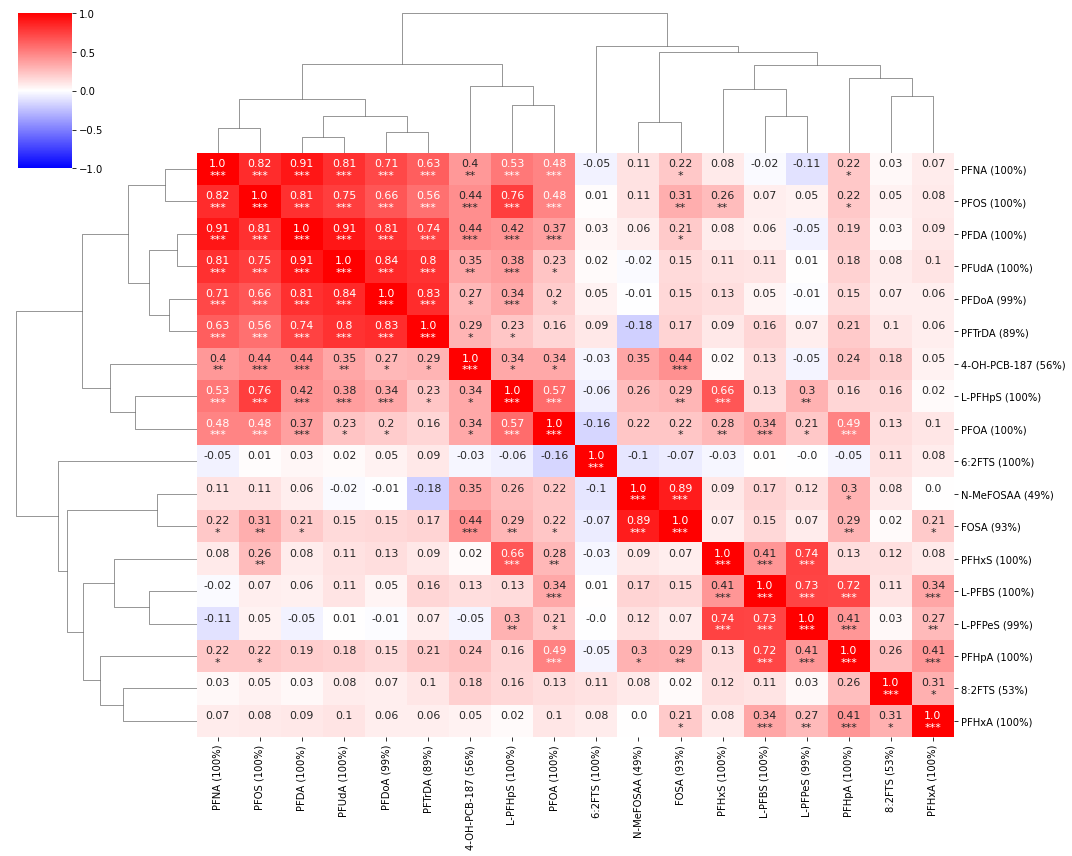

In [50]:
# Correlation plot
import matplotlib.pyplot as plt
import seaborn as sns
cluster_map = sns.clustermap(df, method="complete", cmap='bwr', 
               annot_kws={"size": 11}, vmin=-1, vmax=1, figsize=(15,12),annot=corr_matrix_with_pval,fmt="");

In [52]:
cluster_map.figure.savefig("analysis_results/trace_finder_corr_plot.pdf",dpi=600)